# Сверточные нейронные сети (CNN)
**Цель урока:** понять CNN и написать свою сверточную сеть на PyTorch для распознавания цифр `0..9` (MNIST).

---

## План урока
1) Почему MLP плохо подходит для картинок  
2) Идея свёртки: фильтр (kernel) и “сканирование” изображения  
3) Feature maps, ReLU, MaxPooling — зачем и как  
4) Архитектура CNN для MNIST  
5) Train/Eval loop (как обычно)  
6) Метрики + confusion matrix + разбор ошибок  
7) Сохранение/загрузка модели  
8) Задания


In [1]:
# Если torch/torchvision не установлен (обычно в Colab всё есть):
# !pip install torch torchvision --quiet

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from sklearn.metrics import confusion_matrix, classification_report

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("device:", device)

torch: 2.9.1+cpu
torchvision: 0.24.1+cpu
device: cpu


# 1) Почему MLP хуже CNN на изображениях?

Когда мы делали **MLP**, мы делали:
- Flatten 28×28 → **784** числа
- дальше Linear-слои

Проблема: при Flatten мы **теряем структуру картинки**.
MLP не знает, что пиксели “рядом” — он видит просто длинный список чисел.

**CNN решает это красиво:**
- берёт маленькое “окошко” (например 3×3)
- двигает его по картинке
- ищет локальные паттерны: штрихи, уголки, изгибы

То есть CNN “смотрит как человек”:
- сначала видит маленькие детали
- потом собирает из них более сложные формы


# 2) Идея свёртки: фильтр (kernel)

Представим kernel 3×3 — маленькая матрица чисел:

$$
K =
\begin{bmatrix}
0 & 1 & 0 \\
1 & -4 & 1 \\
0 & 1 & 0
\end{bmatrix}
$$

Мы накладываем этот kernel на кусочек изображения 3×3 и считаем:
- поэлементное умножение
- сумма всех произведений

Это даёт одно число → это “ответ фильтра” в этой позиции.

Двигаем kernel по всему изображению → получаем **карту признаков (feature map)**.

---

### Почему это полезно?
Разные kernels могут находить разные штуки:
- вертикальные линии
- горизонтальные линии
- края (edges)
- углы
- текстуры

Но мы **не подбираем kernel вручную** — CNN учит их автоматически!


# 3) Что такое каналы (channels)?

MNIST: изображение серое, значит **1 канал**:
- форма картинки: `(1, 28, 28)`

Цветное RGB изображение имеет 3 канала:
- `(3, H, W)`

В Conv2d вы задаёте:
- `in_channels`  — сколько каналов на входе
- `out_channels` — сколько фильтров вы хотите выучить

Например:
- Conv2d(1 → 16) означает: “выучи 16 фильтров для серой картинки”
- результат будет иметь 16 каналов: `(16, H', W')`


# 4) Stride и Padding (простая логика)

### Stride (шаг)
- stride=1 → двигаемся по 1 пикселю
- stride=2 → “перепрыгиваем” пиксели, картинка уменьшается быстрее

### Padding (рамка)
- padding=0 → края “обрезаются” сильнее
- padding=1 при kernel=3 → сохраняем размер карты признаков

Для MNIST часто удобно использовать:
- kernel_size=3
- padding=1
- stride=1


# 5) MaxPooling — зачем?

`MaxPool2d(2)` берёт окно 2×2 и оставляет **максимум**.

Это даёт:
- уменьшение размера (H и W в 2 раза)
- меньше вычислений
- сеть становится устойчивее к небольшим сдвигам изображения

Пример:
- (16, 28, 28) → MaxPool2d(2) → (16, 14, 14)


# 6) Загружаем MNIST

Мы используем те же transforms, что и раньше:
- ToTensor()
- Normalize(mean, std)


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

print("train size:", len(train_ds))
print("test size :", len(test_ds))

img, y = train_ds[0]
print("one image shape:", img.shape, "label:", y)

train size: 60000
test size : 10000
one image shape: torch.Size([1, 28, 28]) label: 5


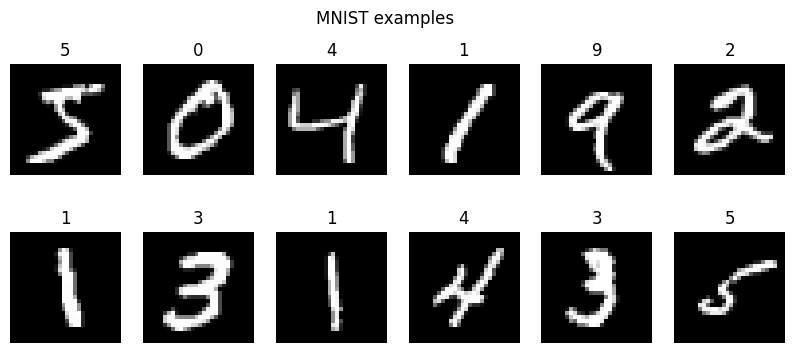

In [3]:
# Посмотрим несколько примеров
plt.figure(figsize=(10,4))
for i in range(12):
    img, label = train_ds[i]
    plt.subplot(2, 6, i+1)
    plt.imshow(img.squeeze(0), cmap="gray")
    plt.title(str(label))
    plt.axis("off")
plt.suptitle("MNIST examples")
plt.show()

# 7) DataLoader — батчи

DataLoader выдаёт:
- Xb: (batch, 1, 28, 28)
- yb: (batch,)


In [4]:
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False)

Xb, yb = next(iter(train_loader))
print("X batch:", Xb.shape)
print("y batch:", yb.shape)

X batch: torch.Size([128, 1, 28, 28])
y batch: torch.Size([128])


# 8) Строим CNN модель для MNIST

Наша сеть будет такой:

1) Conv(1→16, 3×3, padding=1) + ReLU  
2) MaxPool(2×2)  
3) Conv(16→32, 3×3, padding=1) + ReLU  
4) MaxPool(2×2)  
5) Flatten  
6) Linear → 128 + ReLU  
7) Linear → 10 logits

### Проверим размеры!
- вход: (1, 28, 28)
- после pool1: (16, 14, 14)
- после pool2: (32, 7, 7)
- flatten: 32*7*7 = 1568


In [5]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature extractor (извлекает признаки из изображения)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Classifier (классифицирует по извлечённым признакам)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # x: (batch, 1, 28, 28)

        x = self.conv1(x)      # -> (batch, 16, 28, 28)
        x = F.relu(x)          # нелинейность
        x = self.pool(x)       # -> (batch, 16, 14, 14)

        x = self.conv2(x)      # -> (batch, 32, 14, 14)
        x = F.relu(x)
        x = self.pool(x)       # -> (batch, 32, 7, 7)

        x = x.view(x.size(0), -1)  # Flatten -> (batch, 1568)

        x = self.fc1(x)        # -> (batch, 128)
        x = F.relu(x)
        logits = self.fc2(x)   # -> (batch, 10)

        return logits

model = MNIST_CNN().to(device)
print(model)
print("params:", sum(p.numel() for p in model.parameters()))

MNIST_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
params: 206922


# 9) Loss + Optimizer

Для 10-классовой классификации:
- `CrossEntropyLoss`

Она ожидает:
- logits: (batch, 10)
- y: (batch,) целые 0..9

Оптимизатор:
- Adam с lr=1e-3


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("criterion:", type(criterion).__name__)
print("optimizer:", type(optimizer).__name__)

criterion: CrossEntropyLoss
optimizer: Adam


# 10) Train/Eval loop

Точно такой же принцип, как в прошлых уроках:
- model.train() для обучения
- model.eval() + no_grad для проверки

Считаем:
- loss
- accuracy


In [7]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    return total_loss / len(loader.dataset), correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_true = []

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        total_loss += loss.item() * Xb.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)

    return total_loss / len(loader.dataset), correct / total, y_true, y_pred

# 11) Обучение CNN (несколько эпох)

CNN на MNIST обычно быстро выходит на **98%+** accuracy.  
Для урока достаточно 3–6 эпох (особенно если есть GPU).


In [8]:
EPOCHS = 5
history = []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    te_loss, te_acc, _, _ = evaluate(model, test_loader, criterion, device)

    history.append((epoch, tr_loss, tr_acc, te_loss, te_acc))
    print(f"epoch={epoch:02d} | train loss={tr_loss:.4f} acc={tr_acc:.4f} | test loss={te_loss:.4f} acc={te_acc:.4f}")

history

epoch=01 | train loss=0.2288 acc=0.9318 | test loss=0.0641 acc=0.9794
epoch=02 | train loss=0.0607 acc=0.9811 | test loss=0.0488 acc=0.9839
epoch=03 | train loss=0.0423 acc=0.9865 | test loss=0.0408 acc=0.9867
epoch=04 | train loss=0.0318 acc=0.9902 | test loss=0.0374 acc=0.9880
epoch=05 | train loss=0.0257 acc=0.9917 | test loss=0.0309 acc=0.9900


[(1, 0.22879772988557814, 0.9317833333333333, 0.06410740443468094, 0.9794),
 (2, 0.06067259953022003, 0.9810666666666666, 0.0488495690703392, 0.9839),
 (3, 0.04232622047613065, 0.9865, 0.040779962861537934, 0.9867),
 (4, 0.03175211752752463, 0.9902166666666666, 0.03736653083562851, 0.988),
 (5, 0.025731879633665085, 0.9916833333333334, 0.030861131930351258, 0.99)]

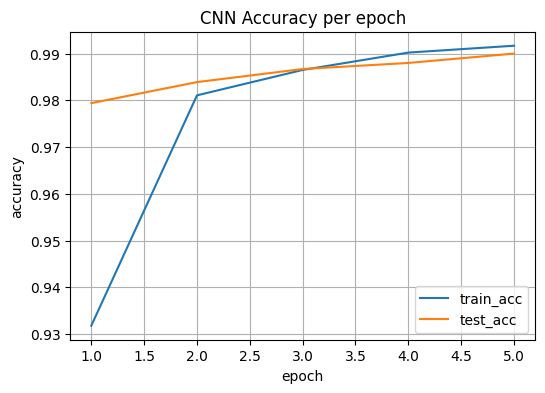

In [9]:
# График точности
hist = np.array(history, dtype=float)
epochs = hist[:,0]
train_acc = hist[:,2]
test_acc  = hist[:,4]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, label="train_acc")
plt.plot(epochs, test_acc,  label="test_acc")
plt.title("CNN Accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.legend()
plt.show()

# 12) Оценка качества: confusion matrix + report

Посмотрим, какие цифры путаются чаще всего.


Test accuracy: 0.99
Report:
               precision    recall  f1-score   support

           0      0.983     0.998     0.990       980
           1      0.996     0.994     0.995      1135
           2      0.994     0.984     0.989      1032
           3      0.978     0.999     0.988      1010
           4      0.992     0.995     0.993       982
           5      0.997     0.983     0.990       892
           6      0.994     0.987     0.991       958
           7      0.987     0.993     0.990      1028
           8      0.990     0.985     0.987       974
           9      0.990     0.981     0.986      1009

    accuracy                          0.990     10000
   macro avg      0.990     0.990     0.990     10000
weighted avg      0.990     0.990     0.990     10000



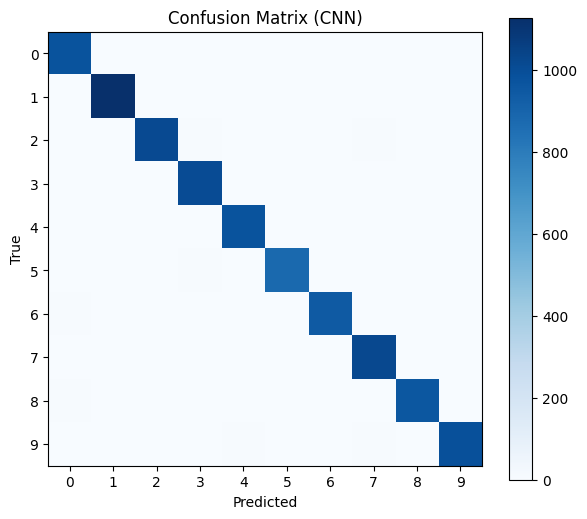

In [10]:
te_loss, te_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)
print("Test accuracy:", te_acc)

cm = confusion_matrix(y_true, y_pred)
print("Report:\n", classification_report(y_true, y_pred, digits=3))

plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (CNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()


# 13) Посмотрим ошибки модели

Выведем несколько картинок, где CNN ошиблась (обычно их будет не так много).


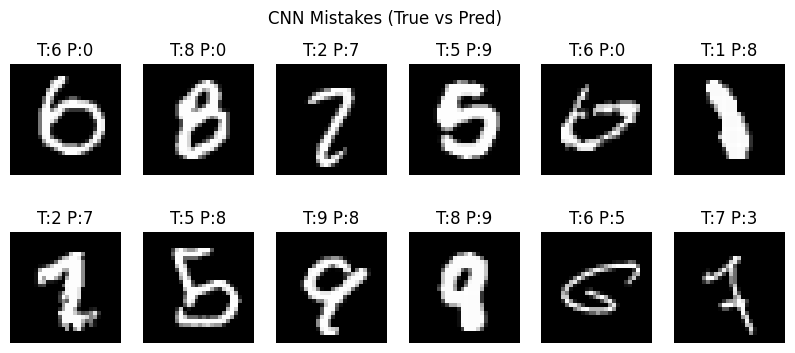

In [11]:
@torch.no_grad()
def show_mistakes(model, dataset, device, n=12):
    model.eval()
    plt.figure(figsize=(10,4))
    shown = 0
    i = 0
    while shown < n and i < len(dataset):
        img, true_label = dataset[i]
        X = img.unsqueeze(0).to(device)  # (1,1,28,28)
        logits = model(X)
        pred = torch.argmax(logits, dim=1).item()
        if pred != true_label:
            plt.subplot(2, 6, shown+1)
            plt.imshow(img.squeeze(0), cmap="gray")
            plt.title(f"T:{true_label} P:{pred}")
            plt.axis("off")
            shown += 1
        i += 1
    plt.suptitle("CNN Mistakes (True vs Pred)")
    plt.show()

show_mistakes(model, test_ds, device, n=12)

# 14) Сохранение/загрузка модели

Сохраняем веса модели в `.pt` через `state_dict`.


In [12]:
MODEL_PATH = "/mnist_cnn_state_dict.pt"

torch.save(model.state_dict(), MODEL_PATH)
print("Saved:", MODEL_PATH)

model_loaded = MNIST_CNN().to(device)
model_loaded.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model_loaded.eval()

te_loss2, te_acc2, _, _ = evaluate(model_loaded, test_loader, criterion, device)
print("Loaded model test acc:", te_acc2)

RuntimeError: File /mnist_cnn_state_dict.pt cannot be opened.

# 15) Инференс: предсказание на одной картинке

Возьмём случайный пример из test и предскажем цифру.


In [ ]:
import random

idx = random.randint(0, len(test_ds)-1)
img, true_label = test_ds[idx]

plt.figure(figsize=(3,3))
plt.imshow(img.squeeze(0), cmap="gray")
plt.title(f"True: {true_label}")
plt.axis("off")
plt.show()

with torch.no_grad():
    X = img.unsqueeze(0).to(device)
    logits = model_loaded(X)
    probs = torch.softmax(logits, dim=1).cpu().numpy().reshape(-1)
    pred = int(np.argmax(probs))

print("Predicted:", pred)
print("Top-3:", np.argsort(probs)[-3:][::-1], np.sort(probs)[-3:][::-1])

In [ ]:
!pip -q install ipycanvas

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from ipycanvas import Canvas
import ipywidgets as widgets
from IPython.display import display, clear_output

import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

canvas_size = 280
canvas = Canvas(width=canvas_size, height=canvas_size, sync_image_data=True)

canvas.fill_style = "black"
canvas.fill_rect(0, 0, canvas_size, canvas_size)

canvas.stroke_style = "white"
canvas.line_width = 18
canvas.line_cap = "round"

out = widgets.Output()

btn_clear = widgets.Button(description="🧹 Clear", button_style="warning")
btn_predict = widgets.Button(description="🔮 Predict", button_style="success")

drawing = {"is_drawing": False, "last_x": None, "last_y": None}

def handle_mousedown(x, y):
    drawing["is_drawing"] = True
    drawing["last_x"], drawing["last_y"] = x, y

def handle_mouseup(x, y):
    drawing["is_drawing"] = False
    drawing["last_x"], drawing["last_y"] = None, None

def handle_mousemove(x, y):
    if not drawing["is_drawing"]:
        return
    lx, ly = drawing["last_x"], drawing["last_y"]
    canvas.begin_path()
    canvas.move_to(lx, ly)
    canvas.line_to(x, y)
    canvas.stroke()
    drawing["last_x"], drawing["last_y"] = x, y

canvas.on_mouse_down(handle_mousedown)
canvas.on_mouse_up(handle_mouseup)
canvas.on_mouse_move(handle_mousemove)

def on_clear(_):
    canvas.fill_style = "black"
    canvas.fill_rect(0, 0, canvas_size, canvas_size)
    with out:
        clear_output()

btn_clear.on_click(on_clear)

def on_predict(_):
    img_rgba = canvas.get_image_data()

    img = img_rgba[:, :, 0].astype(np.float32)

    small = img.reshape(28, 10, 28, 10).mean(axis=(1, 3))

    with out:
        clear_output()
        plt.figure(figsize=(3,3))
        plt.imshow(small, cmap="gray")
        plt.title("Your digit (28x28 preview)")
        plt.axis("off")
        plt.show()

    small_uint8 = small.astype(np.uint8)
    X = mnist_transform(small_uint8).unsqueeze(0).to(device)

    model_loaded.eval()
    with torch.no_grad():
        logits = model_loaded(X)
        probs = torch.softmax(logits, dim=1).cpu().numpy().reshape(-1)
        pred = int(np.argmax(probs))

    top3_idx = np.argsort(probs)[-3:][::-1]
    top3_probs = probs[top3_idx]

    print("Predicted:", pred)
    print("Top-3:", top3_idx, np.round(top3_probs, 4))

btn_predict.on_click(on_predict)

display(widgets.HBox([btn_clear, btn_predict]))
display(canvas, out)

---
# 10 заданий (дополнить код)

**Формат:** задание → подсказка → код с пропусками `_____`  
Заполняйте по порядку.


## Задание 1

**Задание:** Соберите transforms: ToTensor + Normalize для MNIST.

**Подсказка:** `transforms.Compose([...])`, mean=0.1307, std=0.3081


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform


## Задание 2

**Задание:** Загрузите MNIST train/test через datasets.MNIST.

**Подсказка:** `datasets.MNIST(root, train=True/False, download=True, transform=transform)`


In [ ]:
from torchvision import datasets

train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

print(len(train_ds), len(test_ds))

## Задание 3

**Задание:** Создайте DataLoader для train/test.

**Подсказка:** `DataLoader(dataset, batch_size=..., shuffle=...)`


In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Xb, yb = next(iter(train_loader))
print("X:", Xb.shape, "y:", yb.shape)

X: torch.Size([64, 1, 28, 28]) y: torch.Size([64])


## Задание 4

**Задание:** Допишите CNN слой conv1 и conv2 + MaxPool2d.

**Подсказка:** `nn.Conv2d`, `nn.MaxPool2d(kernel_size=2)`


In [15]:
import torch.nn as nn

class StudentCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        return x  # временно

m = StudentCNN()
print(m)

StudentCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Задание 5

**Задание:** Допишите forward: conv→relu→pool→conv→relu→pool→flatten→fc.

**Подсказка:** `F.relu`, `x.view(x.size(0), -1)`


In [16]:
import torch
import torch.nn.functional as F

class StudentCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), 32*7*7)
        x = self.fc1(x)
        x = F.relu(x)
        logits = self.fc2(x)
        return logits

m = StudentCNN()
print("ok")

ok


## Задание 6

**Задание:** Создайте CrossEntropyLoss и Adam optimizer (lr=1e-3).

**Подсказка:** `nn.CrossEntropyLoss()`, `torch.optim.Adam(...)`


In [17]:
import torch
import torch.nn as nn

model = StudentCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(type(criterion).__name__, type(optimizer).__name__)

CrossEntropyLoss Adam


## Задание 7

**Задание:** Сделайте один training step на батче (forward→loss→backward→step).

**Подсказка:** `optimizer.zero_grad()`, `loss.backward()`, `optimizer.step()`


In [18]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StudentCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Xb, yb = next(iter(train_loader))
Xb = Xb.to(device)
yb = yb.to(device)

logits = model(Xb)
loss = criterion(logits, yb)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print("loss:", loss.item())

loss: 2.308077812194824


## Задание 8

**Задание:** Посчитайте accuracy батча: preds = argmax(logits).

**Подсказка:** `torch.argmax(logits, dim=1)`


In [19]:
import torch

preds = torch.argmax(logits, dim=1)
acc = (preds == yb).float().mean().item()
print("batch acc:", acc)

batch acc: 0.078125


## Задание 9

**Задание:** Реализуйте evaluate_student: model.eval()+no_grad+accuracy на test.

**Подсказка:** Соберите все preds/true и верните accuracy


In [20]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluate_student(model, loader, device):
    model.eval()
    all_preds = []
    all_true = []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(yb.numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)
    return accuracy_score(y_true, y_pred)

acc = evaluate_student(model, test_loader, device)
print("test acc:", acc)

test acc: 0.0982


## Задание 10

**Задание:** Сохраните state_dict и загрузите его в новую CNN модель.

**Подсказка:** `torch.save(model.state_dict(), path)` и `load_state_dict(torch.load(...))`


In [23]:
import torch

path = "tmp_cnn.pt"
torch.save(model.state_dict(), path)

model2 = StudentCNN().to(device)
model2.load_state_dict(torch.load(path, map_location=device))
model2.eval()

print("loaded ok")

loaded ok
